# Influenza-A Virus Intrahost Dynamics System Identification

In [4]:
using DrWatson
@quickactivate :ExtendedKalmanFilterNeuralTraining

using Plots, LaTeXStrings

### Initialization of Learning Parameters (params) and Arquitecture (F)

In [6]:
using LinearAlgebra: I, dot

function IAV_model(x::DataFrame, u)
    @assert length(u) == nrow(x)
    E = Dict{String,Any}()
    V = Dict{String,Any}()
    D = Dict{String,Any}()
    params = Dict{String,Any}()
    
    Q = Matrix(1.0e6I, 2, 2)
    R = 1.0e4
    η = 0.93
    P = Matrix(10.0I, 2, 2) 
    ω = rand(2)*1200 
    @pack! E = Q, R, η, P, ω

    Q = Matrix(1.0e6I, 3, 3)
    R = 1.0e4
    η = 0.63
    P = Matrix(1000.0I, 3, 3)
    ω = rand(3)*0.05
    @pack! V = Q, R, η, P, ω

    Q = [1.0e6]
    R = 1.0e4
    η = 0.13
    P = [1.0]
    ω = [rand()*0.05]
    @pack! D = Q, R, η, P, ω

    @pack! params = E, V, D

    ϕ(v) = 1 / (1 + exp(-v))
    F(k) = Dict(
        "E" => (ω -> [dot(ω, [ϕ(val) for val in x[k,["E","V"]]]) + u[k]]), 
        "V" => (ω -> [dot(ω, [ϕ(val) for val in x[k,["E","V","D"]]]) + u[k]]), 
        "D" => (ω -> [ω[1] * ϕ(x[k,"D"]) + u[k]])
        )

    return F, params
end

IAV_model (generic function with 1 method)

### System Simulation and Identification

Simulations are done within Dataframes and ModelingToolkit environments. The explicit definition of the ODESystems can be found in src\\SampleODEs.jl file. 

In [10]:
using ModelingToolkit, DataFrames
using DifferentialEquations: PresetTimeCallback

@named iav = IAV()
display(iav)

IAV_tspan = (0.0,10.0)
IAV_prob = ODEProblem(structural_simplify(iav), [], IAV_tspan);

Model iav with 4 equations
States (4):
  E(t) [defaults to 1.0e6]
  V(t) [defaults to 25.0]
  D(t) [defaults to 0.0]
  η(t) [defaults to 0.0]
Parameters (9):
  k_v [defaults to 1.0e6]
  p [defaults to 4.4]
  c_v [defaults to 1.24e-6]
  S_E [defaults to 20000.0]
⋮

The following case studies can be found in the work of "Recurrent High Order Neural Networks: Identification for Infectious Diseases" by Esteban A. Hernandez-Vargas et. al.

##### Case Study 1: Curative level drug administration started on day 1

In [20]:
curative_treatment_day_1 = PresetTimeCallback(1.0:0.5:max(IAV_tspan...), integrator -> integrator.u[3] += 75.0)
sol = solve(IAV_prob, callback=curative_treatment_day_1)

x = DataFrame(hcat(map(sol, 0.0:0.01:10)...)', ["E", "V", "D"])
u = [k > 100 && (mod(k-1, 50)==0) ? 75.0 : 0.0 for k in 1:1001];

F, params = IAV_model(x, u)
X = train!(F, x, params; algorithm=EKF!());

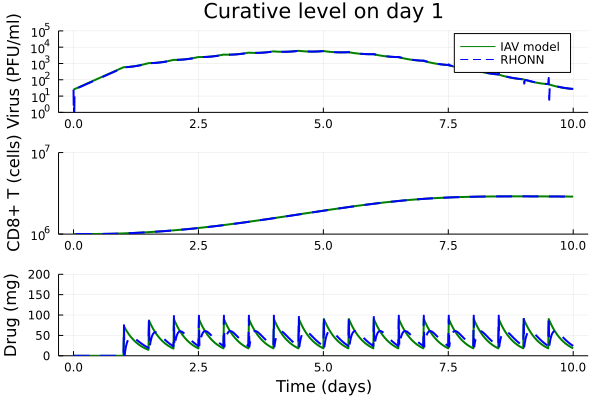

In [21]:
p1 = plot(0:0.01:10, [x[:,"V"], X[:,"V"]], yscale=:log10, yrange=(1.0,1.0e5), xlabel="", ylabel="Virus (PFU/ml)", lw=[2 2], c=[:green :blue], ls=[:solid :dash], label=["IAV model" "RHONN"])
p2 = plot(0:0.01:10, [x[:,"E"], X[:,"E"]], yscale=:log10, yrange=(1.0e6,1.0e7), xlabel="", ylabel="CD8+ T (cells)", lw=[2 2], c=[:green :blue], ls=[:solid :dash], label=false)
p3 = plot(0:0.01:10, [x[:,"D"], X[:,"D"]], yrange=(0.0,200.0), xlabel="Time (days)", ylabel="Drug (mg)", lw=[2 2], c=[:green :blue], ls=[:solid :dash], label=false)
p = plot(p1, p2, p3, layout=(3,1), title=["Curative level on day 1" "" ""] )
#savefig(p, joinpath(plotsdir(), "IAV_curative_day1.png"))

##### Case Study 2: Pandemic level drug administration started on day 2

In [18]:
pandemic_treatment = PresetTimeCallback(2.0:0.5:max(IAV_tspan...), integrator -> integrator.u[3] += 150.0)
sol = solve(IAV_prob, callback=pandemic_treatment)

x = DataFrame(hcat(map(sol, 0.0:0.01:10)...)', ["E", "V", "D"])
u = [k > 100 && (mod(k-1, 50)==0) ? 75.0 : 0.0 for k in 1:1001]

F, params = IAV_model(x, u)
X = train!(F, x, params; algorithm=EKF!());

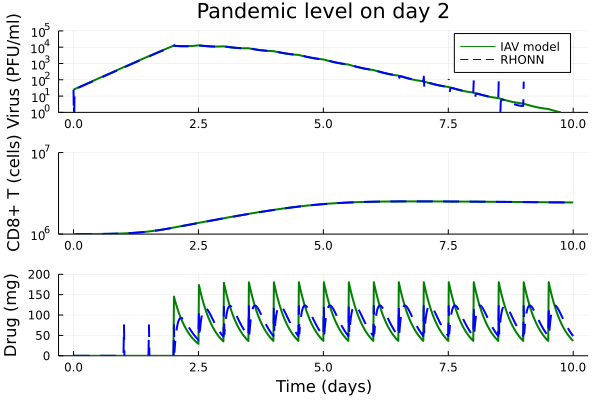

┌ Warning: Invalid negative or zero value -10.962762105606544 found at series index 753 for log10 based yscale
└ @ Plots C:\Users\Daniel I Parra Verde\.julia\packages\Plots\1KWPG\src\utils.jl:95
┌ Warning: Invalid negative or zero value -10.962762105606544 found at series index 753 for log10 based yscale
└ @ Plots C:\Users\Daniel I Parra Verde\.julia\packages\Plots\1KWPG\src\utils.jl:95
┌ Warning: Invalid negative or zero value -10.962762105606544 found at series index 753 for log10 based yscale
└ @ Plots C:\Users\Daniel I Parra Verde\.julia\packages\Plots\1KWPG\src\utils.jl:95


In [19]:
p1 = plot(0:0.01:10, [x[:,"V"], X[:,"V"]], yscale=:log10, yrange=(1.0,1.0e5), xlabel="", ylabel="Virus (PFU/ml)", lw=[2 2], c=[:green :blue], ls=[:solid :dash], label=["IAV model" "RHONN"])
p2 = plot(0:0.01:10, [x[:,"E"], X[:,"E"]], yscale=:log10, yrange=(1.0e6,1.0e7), xlabel="", ylabel="CD8+ T (cells)", lw=[2 2], c=[:green :blue], ls=[:solid :dash], label=false)
p3 = plot(0:0.01:10, [x[:,"D"], X[:,"D"]], yrange=(0.0,200.0), xlabel="Time (days)", ylabel="Drug (mg)", lw=[2 2], c=[:green :blue], ls=[:solid :dash], label=false)
p = plot(p1, p2, p3, layout=(3,1), title=["Pandemic level on day 2" "" ""] )
#savefig(p, joinpath(plotsdir(), "IAV_pandemic_day2.png"))
p

##### Case Study 1: Curative level drug administration started on day 3

In [16]:
curative_treatment_day_3 = PresetTimeCallback(3.0:0.5:max(IAV_tspan...), integrator -> integrator.u[3] += 75.0)
sol = solve(IAV_prob, callback=curative_treatment_day_3)

x = DataFrame(hcat(map(sol, 0.0:0.01:10)...)', ["E", "V", "D"])
u = [k > 100 && (mod(k-1, 50)==0) ? 75.0 : 0.0 for k in 1:1001]

F, params = IAV_model(x, u)
X = train!(F, x, params; algorithm=EKF!());

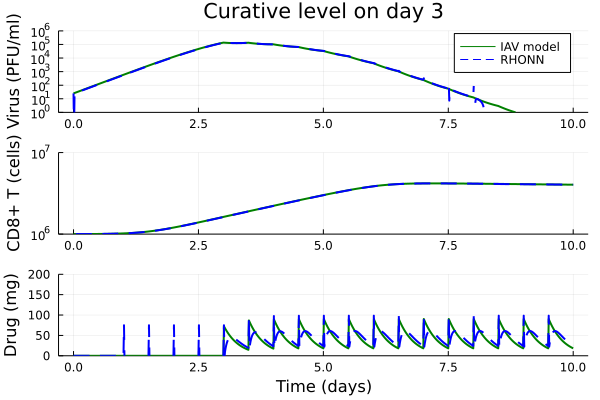

┌ Warning: Invalid negative or zero value -34.626757197489496 found at series index 803 for log10 based yscale
└ @ Plots C:\Users\Daniel I Parra Verde\.julia\packages\Plots\1KWPG\src\utils.jl:95
┌ Warning: Invalid negative or zero value -34.626757197489496 found at series index 803 for log10 based yscale
└ @ Plots C:\Users\Daniel I Parra Verde\.julia\packages\Plots\1KWPG\src\utils.jl:95
┌ Warning: Invalid negative or zero value -34.626757197489496 found at series index 803 for log10 based yscale
└ @ Plots C:\Users\Daniel I Parra Verde\.julia\packages\Plots\1KWPG\src\utils.jl:95


In [17]:
p1 = plot(0:0.01:10, [x[:,"V"], X[:,"V"]], yscale=:log10, yrange=(1.0,1.0e6), xlabel="", ylabel="Virus (PFU/ml)", lw=[2 2], c=[:green :blue], ls=[:solid :dash], label=["IAV model" "RHONN"])
p2 = plot(0:0.01:10, [x[:,"E"], X[:,"E"]], yscale=:log10, yrange=(1.0e6,1.0e7), xlabel="", ylabel="CD8+ T (cells)", lw=[2 2], c=[:green :blue], ls=[:solid :dash], label=false)
p3 = plot(0:0.01:10, [x[:,"D"], X[:,"D"]], yrange=(0.0,200.0), xlabel="Time (days)", ylabel="Drug (mg)", lw=[2 2], c=[:green :blue], ls=[:solid :dash], label=false)
p = plot(p1, p2, p3, layout=(3,1), title=["Curative level on day 3" "" ""] )
#savefig(p, joinpath(plotsdir(), "IAV_curative_day3.png"))
p